## Importing necessary libraries

In [ ]:
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.9/153.9 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.0/199.0 MB 5.0 MB/s eta 0:00:00


In [ ]:
!pip install tensorflow_text

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    auc,
    precision_score,
    recall_score,
    f1_score,
    accuracy_score,
)
from sklearn.feature_extraction.text import TfidfVectorizer
import tensorflow as tf
from tensorflow import keras
from keras.models import load_model
import tensorflow_hub as hub
import tensorflow_text  # Make sure to install this package
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier
import pickle
import os

##Load and Explore the Dataset

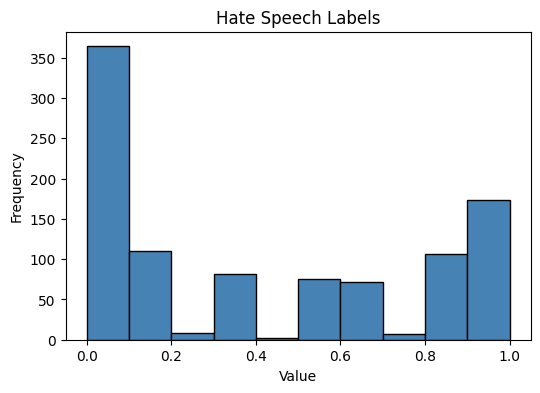

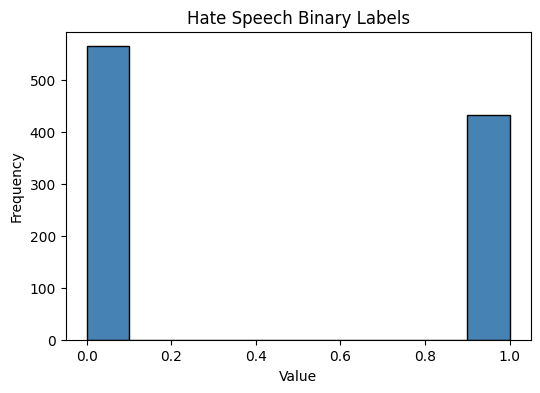

Number of hate speech comments
Hate speech: 433 comments (43.39%)
No Hate Speech: 565 comments (56.61%)


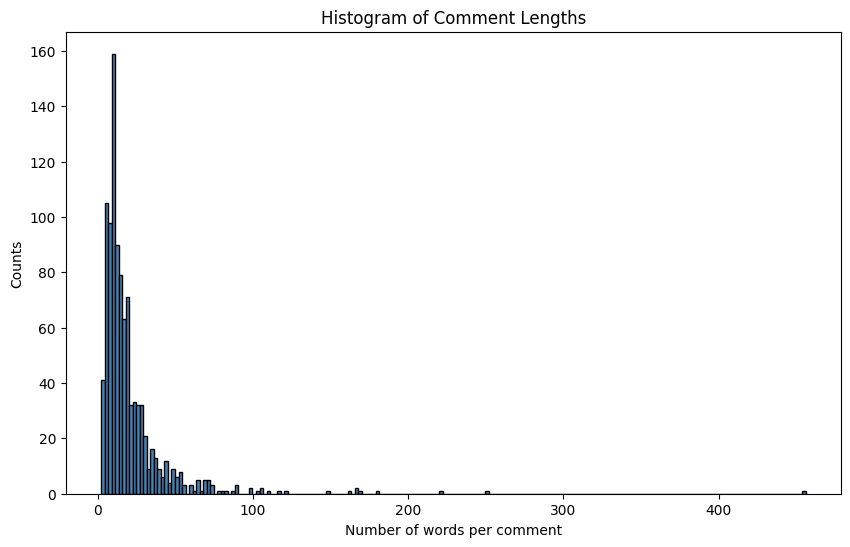

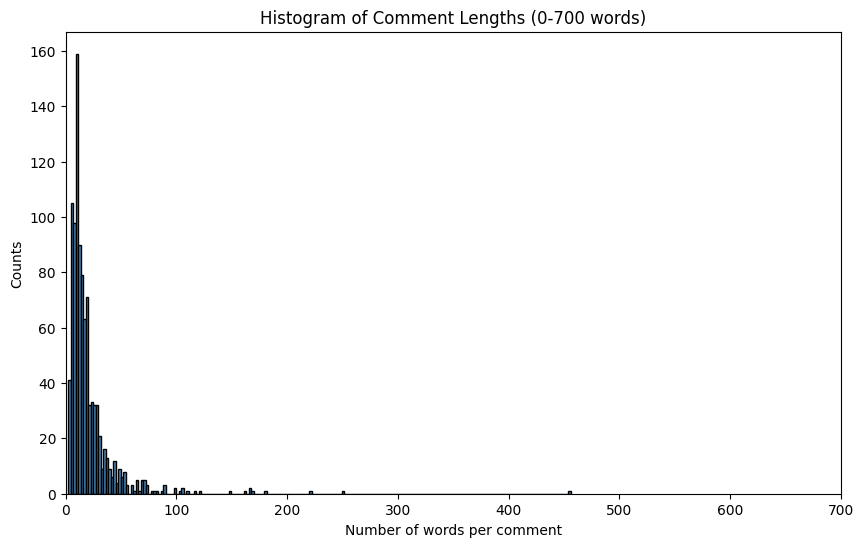

Comment Length
Mean: 20.0 words
Std: 26.0 words
Min: 2 words
Max: 456 words
Here are 10 example comments.
Comment 1: You should know women's sports are a joke
Comment 2: You look like Sloth with deeper Down’s syndrome
Comment 3: You look like Russian and speak like Indian. Both are disgusting go kill yourself
Comment 4: Women deserve to be abused, I guess.
Comment 5: Women are made for making babies and cooking dinner and nothing else!!!
Comment 6: why haven't you faggots taken the bi-pill yet
Comment 7: Why don’t you go beck your god to murder you? Christianity is a joke
Comment 8: why does that african american monkey hold gun like that?
Comment 9: Why does Bulgaria exist as a country? It's one of those homosexual ones.
Comment 10: Why do negroes tear down their own neighborhoods when a black thug gets killed by law enforcement? Must be because of low IQ.


In [ ]:
# Load the dataset
df = pd.read_csv("./Ethos_Dataset_Binary.csv", sep=";")

# Extract comments and labels
comments = df['comment'].values
labels = df['isHate'].values

# Exploratory Data Analysis
def exploratory_data_analysis(comments, labels):
    # Histogram of labels
    plt.figure(figsize=(6, 4))
    plt.hist(labels, color="steelblue", edgecolor="black")
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.title("Hate Speech Labels")
    plt.show()

    # Dichotomize labels
    labels_bin = np.copy(labels)
    labels_bin[labels_bin >= 0.5] = 1
    labels_bin[labels_bin < 0.5] = 0
    labels_bin = labels_bin.astype(int)

    # Histogram of binary labels
    plt.figure(figsize=(6, 4))
    plt.hist(labels_bin, color="steelblue", edgecolor="black")
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.title("Hate Speech Binary Labels")
    plt.show()

    # Label frequencies
    num_hate_comments = len(labels_bin[labels_bin == 1])
    num_no_hate_comments = len(labels_bin[labels_bin == 0])
    percent_hate_comments = np.round(
        num_hate_comments / len(labels_bin) * 100, 2)
    percent_no_hate_comments = np.round(
        num_no_hate_comments / len(labels_bin) * 100, 2)
    print("Number of hate speech comments")
    print(
        f"Hate speech: {num_hate_comments} comments ({percent_hate_comments}%)")
    print(
        f"No Hate Speech: {num_no_hate_comments} comments ({percent_no_hate_comments}%)")
    print("=" * 20)

    # Comment length
    comment_length = [len(comment.split()) for comment in comments]
    # Histogram of comment length
    plt.figure(figsize=(10, 6))
    plt.hist(comment_length, bins=200,
             color="steelblue", edgecolor="black")
    plt.xlabel("Number of words per comment")
    plt.ylabel("Counts")
    plt.title("Histogram of Comment Lengths")
    plt.show()

    # Histogram of comment length from 0 to 700 words
    plt.figure(figsize=(10, 6))
    plt.hist(comment_length, bins=200,
             color="steelblue", edgecolor="black")
    plt.xlabel("Number of words per comment")
    plt.ylabel("Counts")
    plt.title("Histogram of Comment Lengths (0-700 words)")
    plt.xlim(0, 700)
    plt.show()

    # Mean, Std, Min, Max
    print("Comment Length")
    print(f"Mean: {np.round(np.array(comment_length).mean())} words")
    print(f"Std: {np.round(np.array(comment_length).std())} words")
    print(f"Min: {np.round(np.array(comment_length).min())} words")
    print(f"Max: {np.round(np.array(comment_length).max())} words")
    print("=" * 20)

    # Display first 10 comments
    print("Here are 10 example comments.")
    for i in range(10):
        print(f"Comment {i+1}: {comments[i]}")
    print("=" * 20)

    return labels_bin

# Perform EDA
labels = exploratory_data_analysis(comments, labels)

 ## Data Preprocessing

In [ ]:
# Split dataset into training and test data
comments_train, comments_test, labels_train, labels_test = train_test_split(
    comments, labels, test_size=0.3, random_state=42)

# Initialize early stopping (used in all models)
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    mode="max",
    patience=5,
    restore_best_weights=True)

# Specify dropout rate (used in all models)
dropout_rate = 0.5

## Define Evaluation Function

In [ ]:
def evaluate_model(model_name, true_labels, predicted_probs, predicted_labels):
    # Calculate metrics
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels)
    fpr, tpr, _ = roc_curve(true_labels, predicted_probs)
    roc_auc = auc(fpr, tpr)

    # Print classification report
    print(f"\nClassification Report for {model_name}:\n")
    print(classification_report(true_labels, predicted_labels))

    # Confusion Matrix
    conf_matrix = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(6, 4))
    sns.heatmap(
        conf_matrix,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=["No Hate", "Hate"],
        yticklabels=["No Hate", "Hate"],
    )
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # ROC Curve
    plt.figure()
    plt.plot(
        fpr,
        tpr,
        color="darkorange",
        lw=2,
        label=f"ROC Curve (AUC = {roc_auc:.2f})",
    )
    plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    plt.title(f"ROC Curve - {model_name}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.show()

    # Return metrics as a dictionary
    return {
        "Model": model_name,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "AUC": roc_auc,
    }

## Model 1: SimpleRNN



==================== Model 1: SimpleRNN ====================

First 5 padded sequences (SimpleRNN):
[[  27   11    9   25  133   23  312   78  275   11  377   24   23  312
     2]
 [1305    6  378    0    0    0    0    0    0    0    0    0    0    0
     0]
 [  30    5  245  579   31    1  788    2    7  204   18    5 1306   79
   246]
 [ 470  791   47  142   12 1308  380   56 1309   25  276    0    0    0
     0]
 [  52  471   18   10    5  581   29  472   19   55   20  169  381  792
     1]]
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 15, 50)            250050    
                                                                 
 simple_rnn (SimpleRNN)      (None, 15, 128)           22912     
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 128)               32896     
               

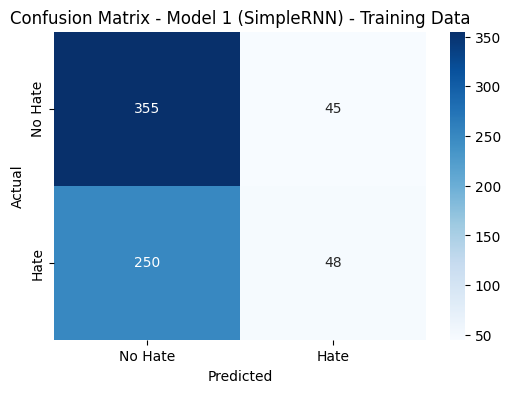

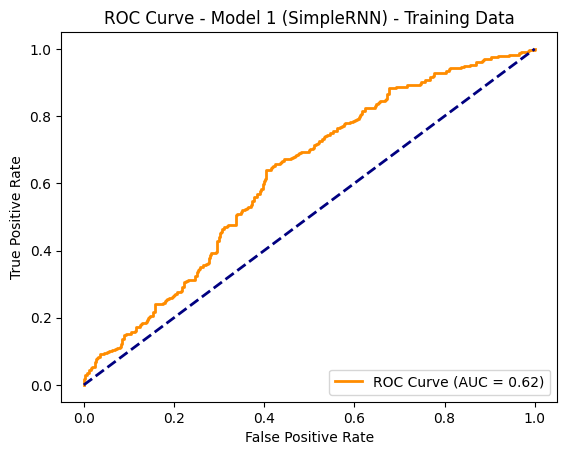

10/10 [==============================] - 0s 4ms/step

Classification Report for Model 1 (SimpleRNN):

              precision    recall  f1-score   support

           0       0.56      0.90      0.69       165
           1       0.56      0.15      0.23       135

    accuracy                           0.56       300
   macro avg       0.56      0.53      0.46       300
weighted avg       0.56      0.56      0.49       300



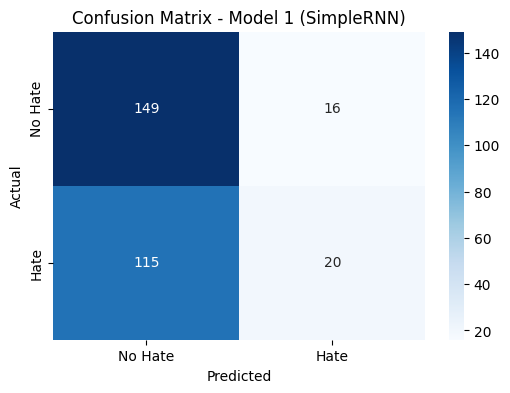

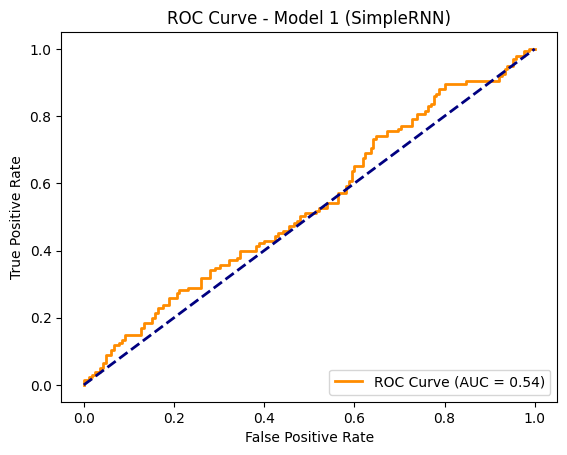

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
print("\n\n==================== Model 1: SimpleRNN ====================\n")

# Initialize tokenizer
num_words = 5000
tokenizer = keras.preprocessing.text.Tokenizer(
    num_words=num_words,
    filters='"!#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
    lower=True,
    split=" ",
    char_level=False,
    oov_token=None
)

# Fit tokenizer to training data
tokenizer.fit_on_texts(comments_train)

# Apply tokenizer to training and test data
sequences_train = tokenizer.texts_to_sequences(comments_train)
sequences_test = tokenizer.texts_to_sequences(comments_test)

# Apply sequence padding
max_length = 15
padded_sequences_train = keras.preprocessing.sequence.pad_sequences(
    sequences_train,
    maxlen=max_length,
    truncating="post",
    padding="post"
)
padded_sequences_test = keras.preprocessing.sequence.pad_sequences(
    sequences_test,
    maxlen=max_length,
    truncating="post",
    padding="post"
)

# Display first 5 padded sequences
print("First 5 padded sequences (SimpleRNN):")
print(padded_sequences_train[:5])

# Define the model
word_vector_dim = 50
model1 = keras.models.Sequential([
    keras.layers.Embedding(
        num_words + 1,
        word_vector_dim,
        input_length=max_length,
        mask_zero=True
    ),
    keras.layers.SimpleRNN(
        128,
        return_sequences=True,
        dropout=dropout_rate,
        recurrent_dropout=dropout_rate
    ),
    keras.layers.SimpleRNN(
        128,
        dropout=dropout_rate,
        recurrent_dropout=dropout_rate
    ),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid")
])

# Summarize model
model1.summary()

# Compile model
model1.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

# Fit model
model1_history = model1.fit(
    padded_sequences_train,
    labels_train,
    epochs=100,
    batch_size=8,
    validation_data=(padded_sequences_test, labels_test),
    callbacks=[early_stopping]
)
# Evaluate on training data
train_predictions = model1.predict(padded_sequences_train).flatten()
train_predicted_labels = (train_predictions > 0.5).astype(int)

# Evaluate using the unified function
model1_train_results = evaluate_model(
    model_name="Model 1 (SimpleRNN) - Training Data",
    true_labels=labels_train,
    predicted_probs=train_predictions,
    predicted_labels=train_predicted_labels,
)

# Evaluate model
predictions = model1.predict(padded_sequences_test).flatten()
predicted_labels = (predictions > 0.5).astype(int)

# Evaluate using the unified function
model1_results = evaluate_model(
    model_name="Model 1 (SimpleRNN)",
    true_labels=labels_test,
    predicted_probs=predictions,
    predicted_labels=predicted_labels,
)

# Save tokenizer and model
with open('tokenizer_model1.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)
model1.save('model1.h5')

## Model 2: LSTM



======================= Model 2: LSTM =======================

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 15, 50)            250050    
                                                                 
 lstm (LSTM)                 (None, 15, 128)           91648     
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 481603 (1.84 MB)
Trainable params: 481603 (1.84 MB)
Non-trainable params: 0 (0.00 Byte)
___________________

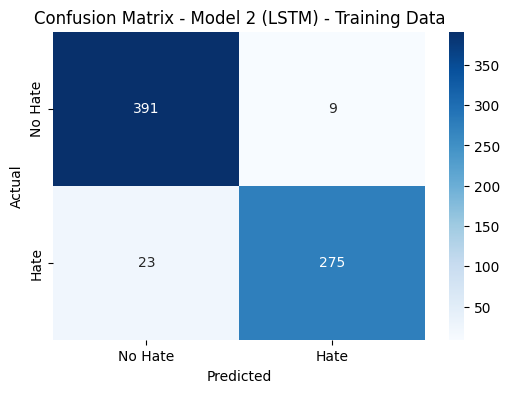

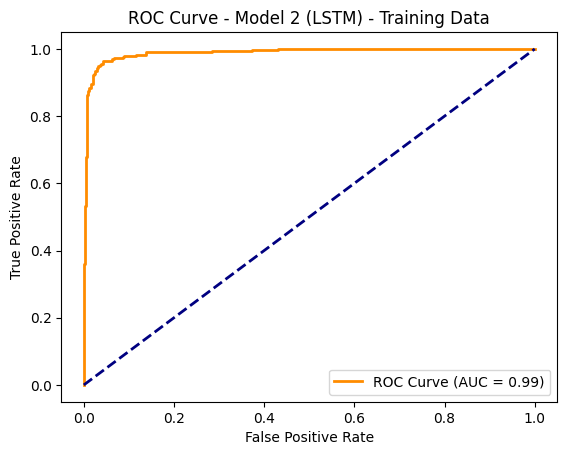

10/10 [==============================] - 0s 7ms/step

Classification Report for Model 2 (LSTM):

              precision    recall  f1-score   support

           0       0.66      0.75      0.70       165
           1       0.63      0.53      0.58       135

    accuracy                           0.65       300
   macro avg       0.65      0.64      0.64       300
weighted avg       0.65      0.65      0.65       300



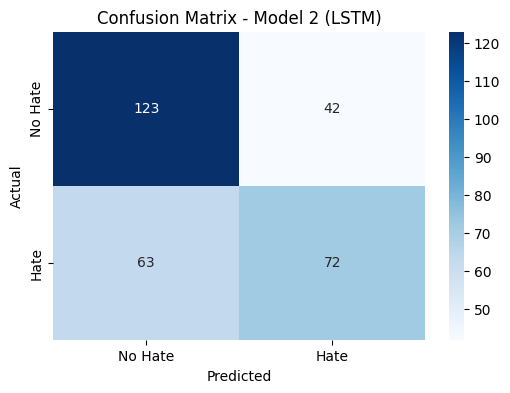

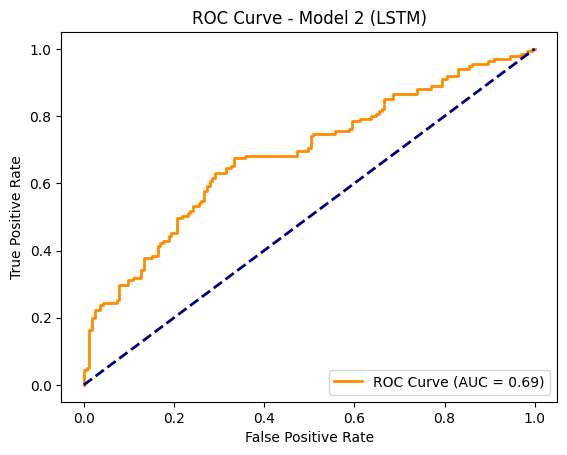

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
print("\n\n======================= Model 2: LSTM =======================\n")

# Define the model
model2 = keras.models.Sequential([
    keras.layers.Embedding(
        num_words + 1,
        word_vector_dim,
        input_length=max_length,
        mask_zero=True
    ),
    keras.layers.LSTM(
        128,
        return_sequences=True,
        dropout=dropout_rate,
        recurrent_dropout=dropout_rate
    ),
    keras.layers.LSTM(
        128,
        dropout=dropout_rate,
        recurrent_dropout=dropout_rate
    ),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid")
])

# Summarize model
model2.summary()

# Compile model
model2.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

# Fit model
model2_history = model2.fit(
    padded_sequences_train,
    labels_train,
    epochs=100,
    batch_size=32,
    validation_data=(padded_sequences_test, labels_test),
    callbacks=[early_stopping]
)
# Evaluate on training data
train_predictions = model2.predict(padded_sequences_train).flatten()
train_predicted_labels = (train_predictions > 0.5).astype(int)

# Evaluate using the unified function
model2_train_results = evaluate_model(
    model_name="Model 2 (LSTM) - Training Data",
    true_labels=labels_train,
    predicted_probs=train_predictions,
    predicted_labels=train_predicted_labels,
)

# Evaluate model
predictions = model2.predict(padded_sequences_test).flatten()
predicted_labels = (predictions > 0.5).astype(int)

# Evaluate using the unified function
model2_results = evaluate_model(
    model_name="Model 2 (LSTM)",
    true_labels=labels_test,
    predicted_probs=predictions,
    predicted_labels=predicted_labels,
)

# Save model
model2.save('model2.h5')

## Model 3: Fine-tuned BERT



================== Model 3: Fine-tuned BERT ==================

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text (InputLayer)           [(None,)]                    0         []                            
                                                                                                  
 preprocessing (KerasLayer)  {'input_type_ids': (None,    0         ['text[0][0]']                
                             128),                                                                
                              'input_mask': (None, 128)                                           
                             , 'input_word_ids': (None,                                           
                              128)}                                                               
                            

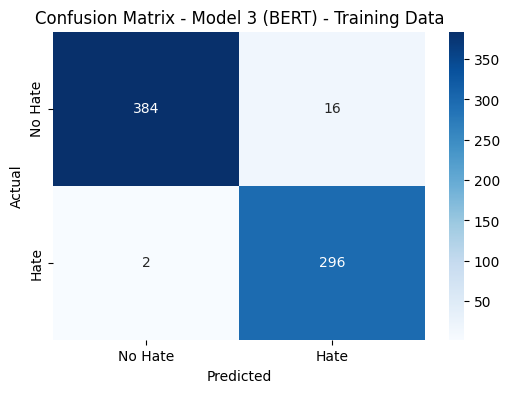

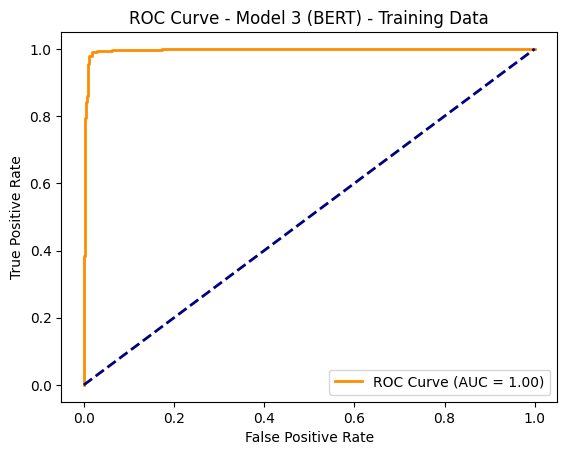

10/10 [==============================] - 3s 261ms/step

Classification Report for Model 3 (BERT):

              precision    recall  f1-score   support

           0       0.83      0.72      0.77       165
           1       0.70      0.81      0.75       135

    accuracy                           0.76       300
   macro avg       0.76      0.76      0.76       300
weighted avg       0.77      0.76      0.76       300



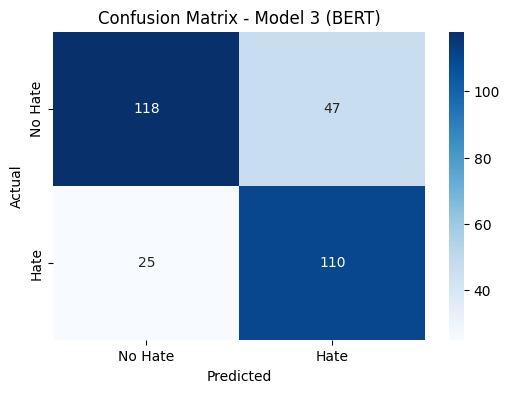

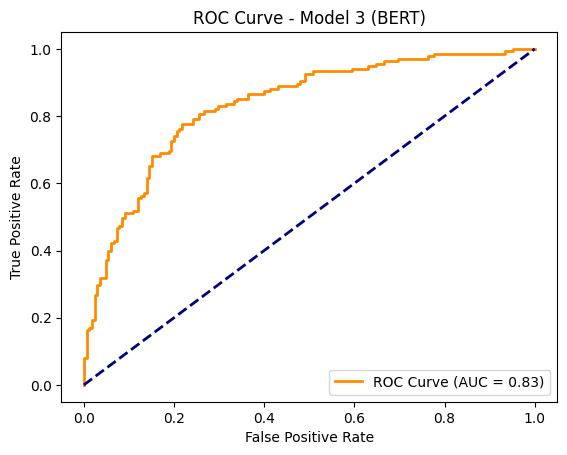

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
print("\n\n================== Model 3: Fine-tuned BERT ==================\n")

# Define the model
text_input = keras.layers.Input(shape=(), dtype=tf.string, name="text")
preprocessor = hub.KerasLayer(
    "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3",
    name="preprocessing"
)
preprocessed_inputs = preprocessor(text_input)
bert = hub.KerasLayer(
    "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/2",
    trainable=True,
    name="BERT"
)
bert_outputs = bert(preprocessed_inputs)
pooled_output = bert_outputs["pooled_output"]
pooled_output = keras.layers.Dropout(dropout_rate)(pooled_output)
dense = keras.layers.Dense(128, activation="relu")(pooled_output)
outputs = keras.layers.Dense(1, activation="sigmoid", name="classifier")(dense)
model3 = keras.Model(inputs=text_input, outputs=outputs)

# Summarize model
model3.summary()

# Compile model
model3.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

# Fit model
model3_history = model3.fit(
    comments_train,
    labels_train,
    epochs=100,
    batch_size=8,
    validation_data=(comments_test, labels_test),
    callbacks=[early_stopping]
)
# Evaluate on training data
train_labels_pred_prob_model3 = model3.predict(comments_train).flatten()
train_labels_pred_model3 = (train_labels_pred_prob_model3 >= 0.5).astype(int)

# Evaluate using the unified function
model3_train_results = evaluate_model(
    model_name="Model 3 (BERT) - Training Data",
    true_labels=labels_train,
    predicted_probs=train_labels_pred_prob_model3,
    predicted_labels=train_labels_pred_model3,
)

# Evaluate model
labels_pred_prob_model3 = model3.predict(comments_test).flatten()
labels_pred_model3 = (labels_pred_prob_model3 >= 0.5).astype(int)

# Evaluate using the unified function
model3_results = evaluate_model(
    model_name="Model 3 (BERT)",
    true_labels=labels_test,
    predicted_probs=labels_pred_prob_model3,
    predicted_labels=labels_pred_model3,
)

# Save model
model3.save('model3.h5')

## Model 4: XGBoost



===================== Model 4: XGBoost ======================

TF-IDF Train Shape: (698, 5000)
TF-IDF Test Shape: (300, 5000)


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:08:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Classification Report for Model 4 (XGBoost) - Training Data:

              precision    recall  f1-score   support

           0       0.81      0.98      0.89       400
           1       0.97      0.69      0.81       298

    accuracy                           0.86       698
   macro avg       0.89      0.84      0.85       698
weighted avg       0.88      0.86      0.85       698



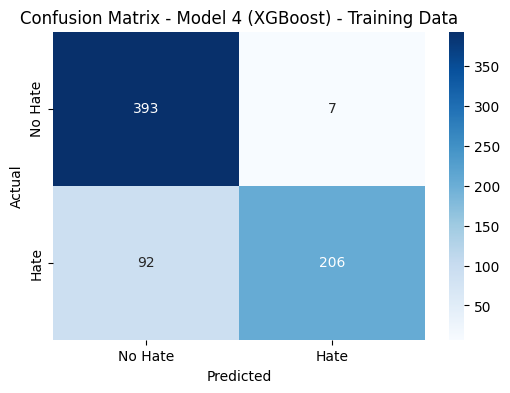

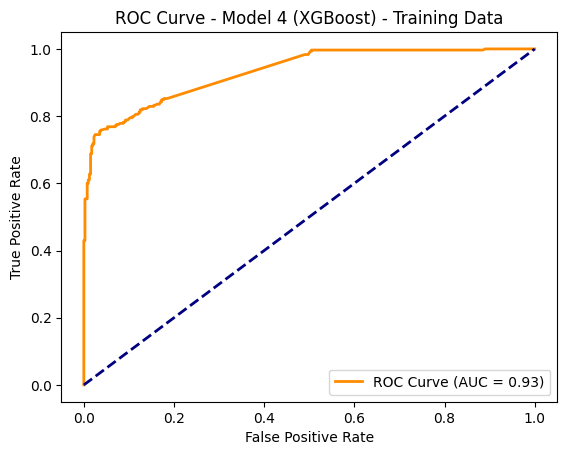


Classification Report for Model 4 (XGBoost):

              precision    recall  f1-score   support

           0       0.61      0.83      0.70       165
           1       0.63      0.35      0.45       135

    accuracy                           0.61       300
   macro avg       0.62      0.59      0.58       300
weighted avg       0.62      0.61      0.59       300



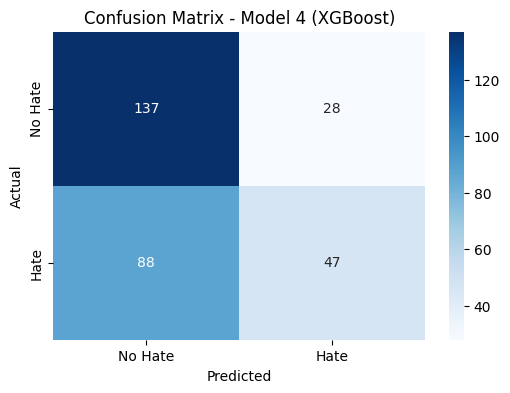

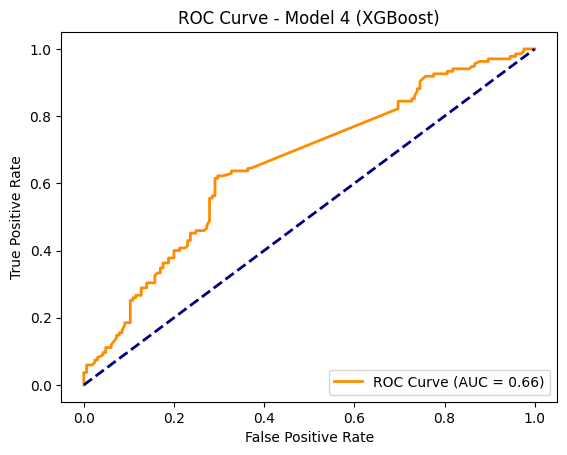

In [ ]:
print("\n\n===================== Model 4: XGBoost ======================\n")

# Initialize TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    stop_words='english'
)

# Fit and transform the training data
X_train_tfidf = tfidf_vectorizer.fit_transform(comments_train)

# Transform the testing data
X_test_tfidf = tfidf_vectorizer.transform(comments_test)

# Display the shape of the transformed data
print(f"TF-IDF Train Shape: {X_train_tfidf.shape}")
print(f"TF-IDF Test Shape: {X_test_tfidf.shape}")

# Initialize and train the model
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)
xgb_model.fit(X_train_tfidf, labels_train)

# Predict on training data
labels_train_pred_xgb = xgb_model.predict(X_train_tfidf)
labels_train_pred_prob_xgb = xgb_model.predict_proba(X_train_tfidf)[:, 1]

# Evaluate using the unified function
model4_train_results = evaluate_model(
    model_name="Model 4 (XGBoost) - Training Data",
    true_labels=labels_train,
    predicted_probs=labels_train_pred_prob_xgb,
    predicted_labels=labels_train_pred_xgb,
)

# Predict on testing data
labels_test_pred_xgb = xgb_model.predict(X_test_tfidf)
labels_test_pred_prob_xgb = xgb_model.predict_proba(X_test_tfidf)[:, 1]

# Evaluate using the unified function
model4_results = evaluate_model(
    model_name="Model 4 (XGBoost)",
    true_labels=labels_test,
    predicted_probs=labels_test_pred_prob_xgb,
    predicted_labels=labels_test_pred_xgb,
)

# Save the model and vectorizer
os.makedirs('saved_models', exist_ok=True)
with open('saved_models/xgb_model.pkl', 'wb') as file:
    pickle.dump(xgb_model, file)
with open('saved_models/tfidf_vectorizer.pkl', 'wb') as file:
    pickle.dump(tfidf_vectorizer, file)

## Ensemble Methods



===================== Ensemble Methods ======================


--- Bagging Classifier ---


Classification Report for Bagging Classifier - Training Data:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       298

    accuracy                           1.00       698
   macro avg       1.00      1.00      1.00       698
weighted avg       1.00      1.00      1.00       698



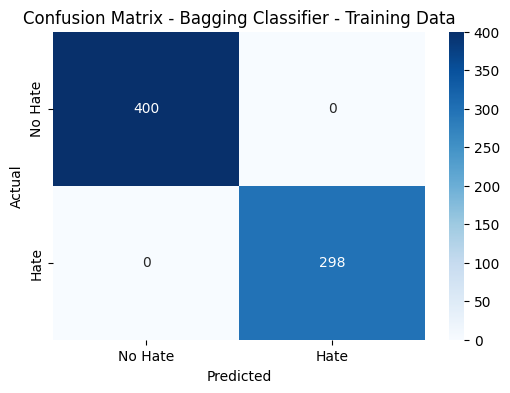

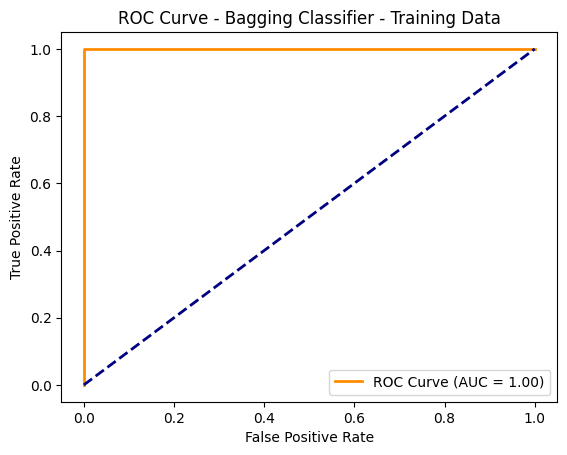


Classification Report for Bagging Classifier:

              precision    recall  f1-score   support

           0       0.65      0.78      0.71       165
           1       0.65      0.50      0.56       135

    accuracy                           0.65       300
   macro avg       0.65      0.64      0.64       300
weighted avg       0.65      0.65      0.65       300



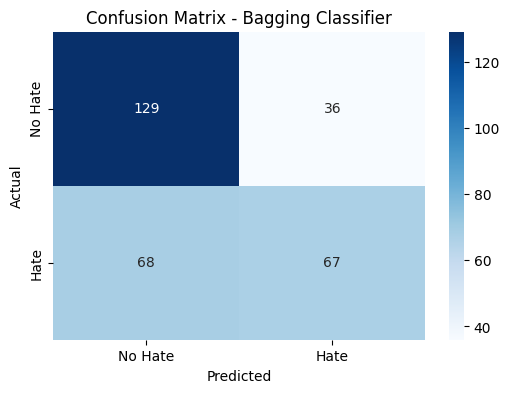

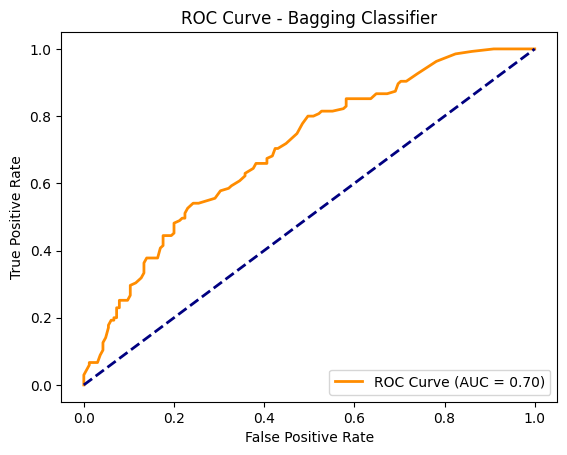


--- Boosting Classifier ---



/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(



Classification Report for Boosting Classifier - Training Data:

              precision    recall  f1-score   support

           0       0.87      0.95      0.91       400
           1       0.93      0.81      0.86       298

    accuracy                           0.89       698
   macro avg       0.90      0.88      0.89       698
weighted avg       0.89      0.89      0.89       698



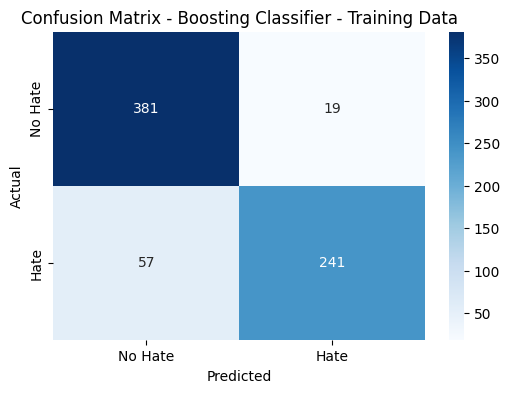

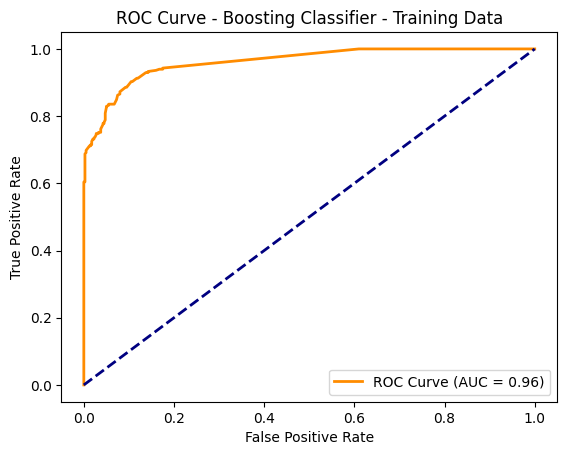


Classification Report for Boosting Classifier:

              precision    recall  f1-score   support

           0       0.64      0.71      0.67       165
           1       0.59      0.50      0.54       135

    accuracy                           0.62       300
   macro avg       0.61      0.61      0.61       300
weighted avg       0.61      0.62      0.61       300



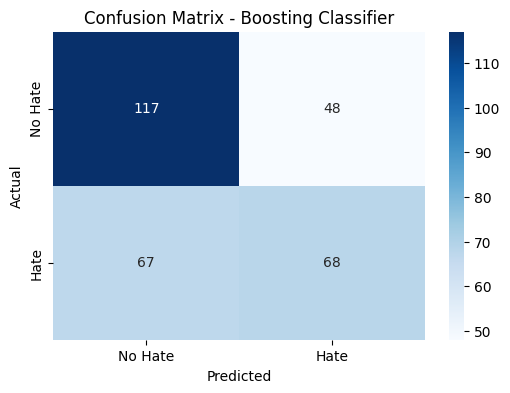

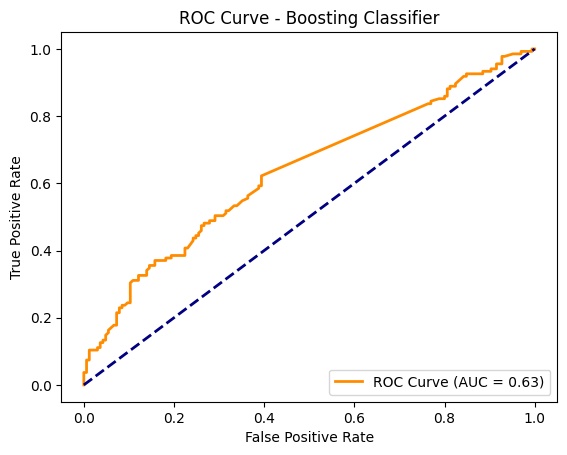


--- Stacking Classifier ---



/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:09:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:09:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:09:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Classification Report for Stacking Classifier - Training Data:

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       400
           1       1.00      0.98      0.99       298

    accuracy                           0.99       698
   macro avg       0.99      0.99      0.99       698
weighted avg       0.99      0.99      0.99       698



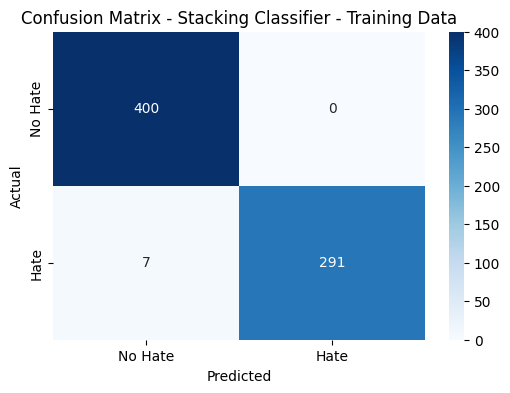

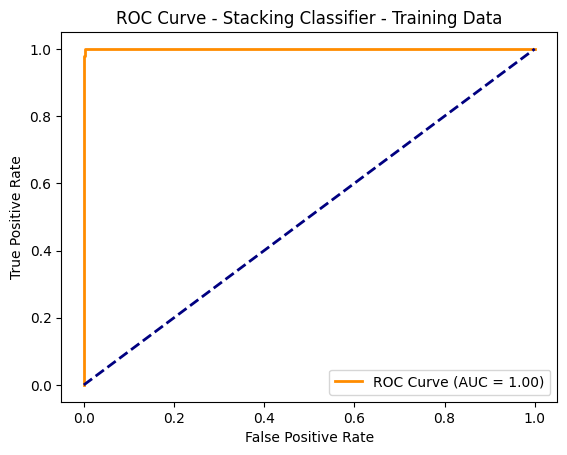


Classification Report for Stacking Classifier:

              precision    recall  f1-score   support

           0       0.65      0.78      0.71       165
           1       0.64      0.50      0.56       135

    accuracy                           0.65       300
   macro avg       0.65      0.64      0.63       300
weighted avg       0.65      0.65      0.64       300



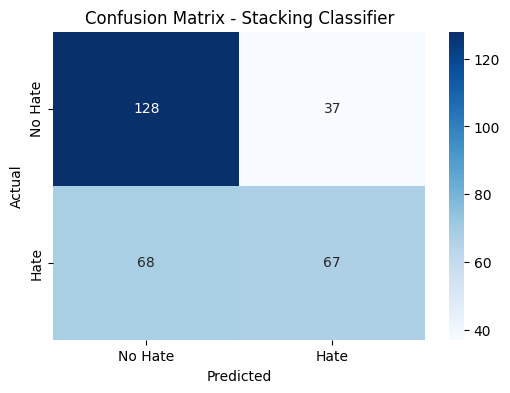

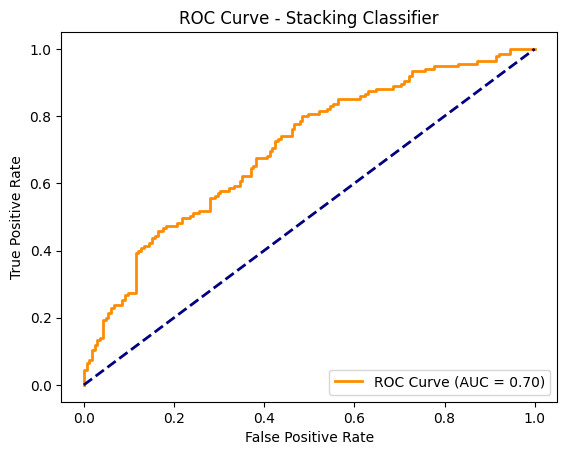


--- Voting Classifier ---



/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:09:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:09:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:09:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Classification Report for Voting Classifier - Training Data:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       298

    accuracy                           1.00       698
   macro avg       1.00      1.00      1.00       698
weighted avg       1.00      1.00      1.00       698



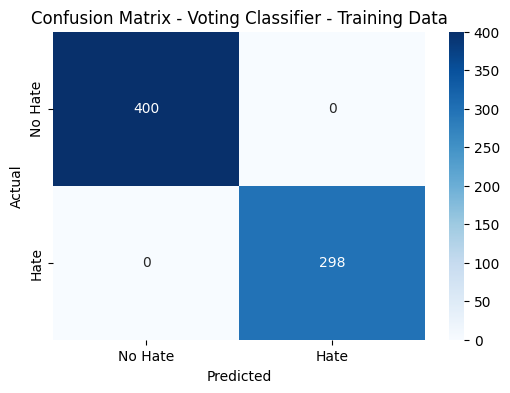

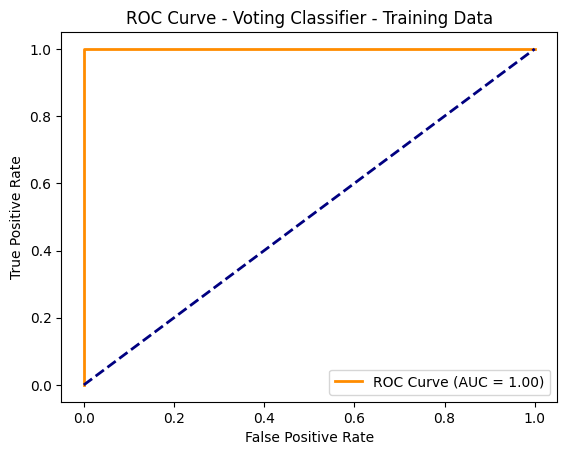


Classification Report for Voting Classifier:

              precision    recall  f1-score   support

           0       0.64      0.79      0.71       165
           1       0.64      0.45      0.53       135

    accuracy                           0.64       300
   macro avg       0.64      0.62      0.62       300
weighted avg       0.64      0.64      0.63       300



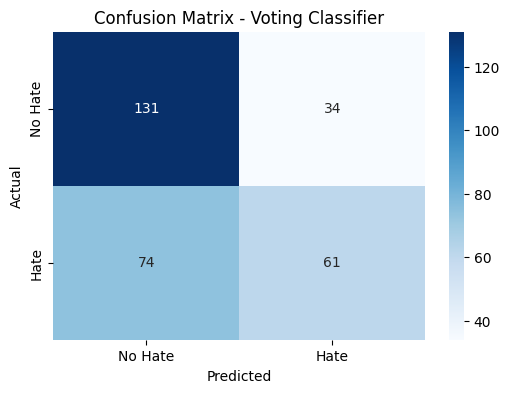

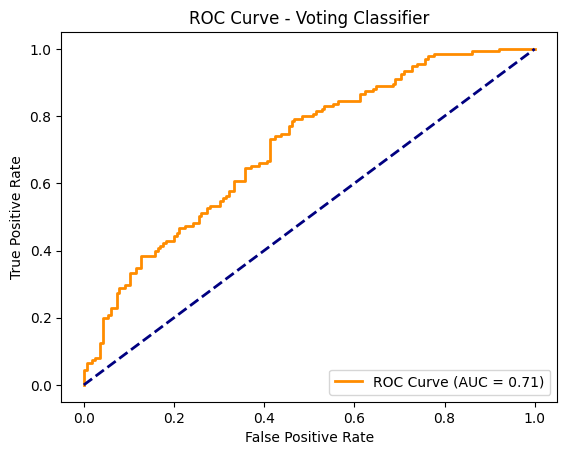

In [ ]:
print("\n\n===================== Ensemble Methods ======================\n")

from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, StackingClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

# ------------------------- Bagging Classifier -------------------------
print("\n--- Bagging Classifier ---\n")

bagging_clf = BaggingClassifier(
    estimator=DecisionTreeClassifier(),
    n_estimators=100,
    random_state=42
)
bagging_clf.fit(X_train_tfidf, labels_train)

# Predict on training data
bagging_pred_prob_train = bagging_clf.predict_proba(X_train_tfidf)[:, 1]
bagging_pred_train = (bagging_pred_prob_train >= 0.5).astype(int)

# Evaluate using the unified function
bagging_train_results = evaluate_model(
    model_name="Bagging Classifier - Training Data",
    true_labels=labels_train,
    predicted_probs=bagging_pred_prob_train,
    predicted_labels=bagging_pred_train,
)


# Predict and evaluate
bagging_pred_prob = bagging_clf.predict_proba(X_test_tfidf)[:, 1]
bagging_pred = (bagging_pred_prob >= 0.5).astype(int)

# Evaluate using the unified function
bagging_results = evaluate_model(
    model_name="Bagging Classifier",
    true_labels=labels_test,
    predicted_probs=bagging_pred_prob,
    predicted_labels=bagging_pred,
)

# ------------------------- Boosting Classifier -------------------------
print("\n--- Boosting Classifier ---\n")

boosting_clf = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1),
    n_estimators=100,
    random_state=42
)
boosting_clf.fit(X_train_tfidf, labels_train)

# Predict on training data
boosting_pred_prob_train = boosting_clf.predict_proba(X_train_tfidf)[:, 1]
boosting_pred_train = (boosting_pred_prob_train >= 0.5).astype(int)

# Evaluate using the unified function
boosting_train_results = evaluate_model(
    model_name="Boosting Classifier - Training Data",
    true_labels=labels_train,
    predicted_probs=boosting_pred_prob_train,
    predicted_labels=boosting_pred_train,
)


# Predict and evaluate
boosting_pred_prob = boosting_clf.predict_proba(X_test_tfidf)[:, 1]
boosting_pred = (boosting_pred_prob >= 0.5).astype(int)

# Evaluate using the unified function
boosting_results = evaluate_model(
    model_name="Boosting Classifier",
    true_labels=labels_test,
    predicted_probs=boosting_pred_prob,
    predicted_labels=boosting_pred,
)

# ------------------------- Stacking Classifier -------------------------
print("\n--- Stacking Classifier ---\n")

stacking_clf = StackingClassifier(
    estimators=[
        ('xgboost', xgb_model),
        ('decision_tree', DecisionTreeClassifier()),
        ('log_reg', LogisticRegression(max_iter=1000))
    ],
    final_estimator=LogisticRegression(),
    passthrough=False
)
stacking_clf.fit(X_train_tfidf, labels_train)

# Predict on training data
stacking_pred_prob_train = stacking_clf.predict_proba(X_train_tfidf)[:, 1]
stacking_pred_train = (stacking_pred_prob_train >= 0.5).astype(int)

# Evaluate using the unified function
stacking_train_results = evaluate_model(
    model_name="Stacking Classifier - Training Data",
    true_labels=labels_train,
    predicted_probs=stacking_pred_prob_train,
    predicted_labels=stacking_pred_train,
)


# Predict and evaluate
stacking_pred_prob = stacking_clf.predict_proba(X_test_tfidf)[:, 1]
stacking_pred = (stacking_pred_prob >= 0.5).astype(int)

# Evaluate using the unified function
stacking_results = evaluate_model(
    model_name="Stacking Classifier",
    true_labels=labels_test,
    predicted_probs=stacking_pred_prob,
    predicted_labels=stacking_pred,
)

# ------------------------- Voting Classifier -------------------------
print("\n--- Voting Classifier ---\n")

voting_clf = VotingClassifier(
    estimators=[
        ('bagging', bagging_clf),
        ('boosting', boosting_clf),
        ('stacking', stacking_clf)
    ],
    voting='soft'
)
voting_clf.fit(X_train_tfidf, labels_train)

# Predict on training data
voting_pred_prob_train = voting_clf.predict_proba(X_train_tfidf)[:, 1]
voting_pred_train = (voting_pred_prob_train >= 0.5).astype(int)

# Evaluate using the unified function
voting_train_results = evaluate_model(
    model_name="Voting Classifier - Training Data",
    true_labels=labels_train,
    predicted_probs=voting_pred_prob_train,
    predicted_labels=voting_pred_train,
)


# Predict and evaluate
voting_pred_prob = voting_clf.predict_proba(X_test_tfidf)[:, 1]
voting_pred = (voting_pred_prob >= 0.5).astype(int)

# Evaluate using the unified function
voting_results = evaluate_model(
    model_name="Voting Classifier",
    true_labels=labels_test,
    predicted_probs=voting_pred_prob,
    predicted_labels=voting_pred,
)


## Compile and Display Results



===================== Training Data Evaluation Metrics =====================



,Accuracy,Precision,Recall,F1 Score,AUC
Model,,,,,
Model 1 (SimpleRNN) - Training Data,0.577364,0.516129,0.161074,0.245524,0.624371
Model 2 (LSTM) - Training Data,0.954155,0.968310,0.922819,0.945017,0.989010
Model 3 (BERT) - Training Data,0.974212,0.948718,0.993289,0.970492,0.996275
Model 4 (XGBoost) - Training Data,0.858166,0.967136,0.691275,0.806262,0.931686
Bagging Classifier - Training Data,1.000000,1.000000,1.000000,1.000000,1.000000
Boosting Classifier - Training Data,0.891117,0.926923,0.808725,0.863799,0.961552
Stacking Classifier - Training Data,0.989971,1.000000,0.976510,0.988115,0.999950
Voting Classifier - Training Data,1.000000,1.000000,1.000000,1.000000,1.000000




===================== Testing Data Evaluation Metrics =====================



,Accuracy,Precision,Recall,F1 Score,AUC
Model,,,,,
Model 1 (SimpleRNN),0.563333,0.555556,0.148148,0.233918,0.536386
Model 2 (LSTM),0.650000,0.631579,0.533333,0.578313,0.686375
Model 3 (BERT),0.760000,0.700637,0.814815,0.753425,0.833850
Model 4 (XGBoost),0.613333,0.626667,0.348148,0.447619,0.657172
Bagging Classifier,0.653333,0.650485,0.496296,0.563025,0.700292
Boosting Classifier,0.616667,0.586207,0.503704,0.541833,0.634523
Stacking Classifier,0.650000,0.644231,0.496296,0.560669,0.704332
Voting Classifier,0.640000,0.642105,0.451852,0.530435,0.707520


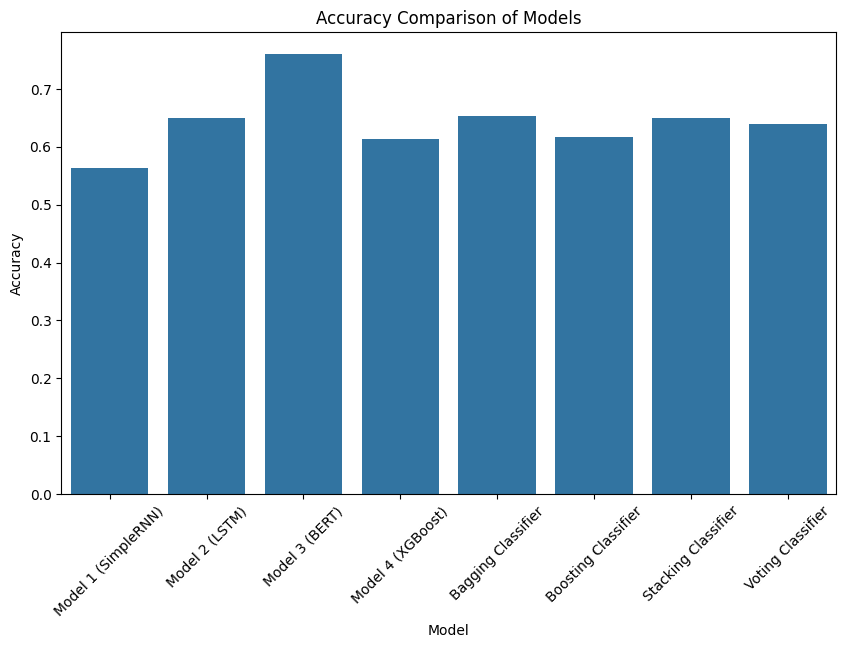

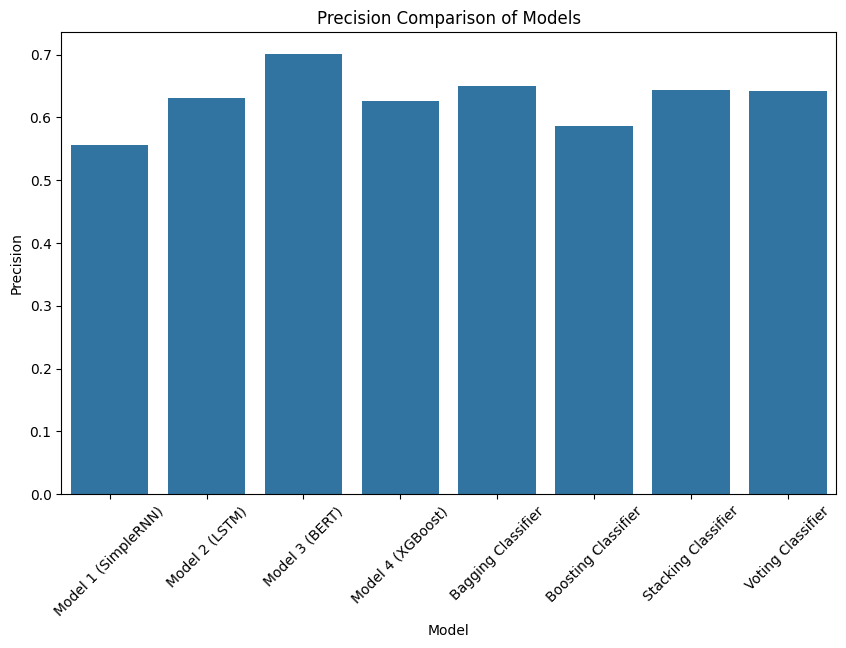

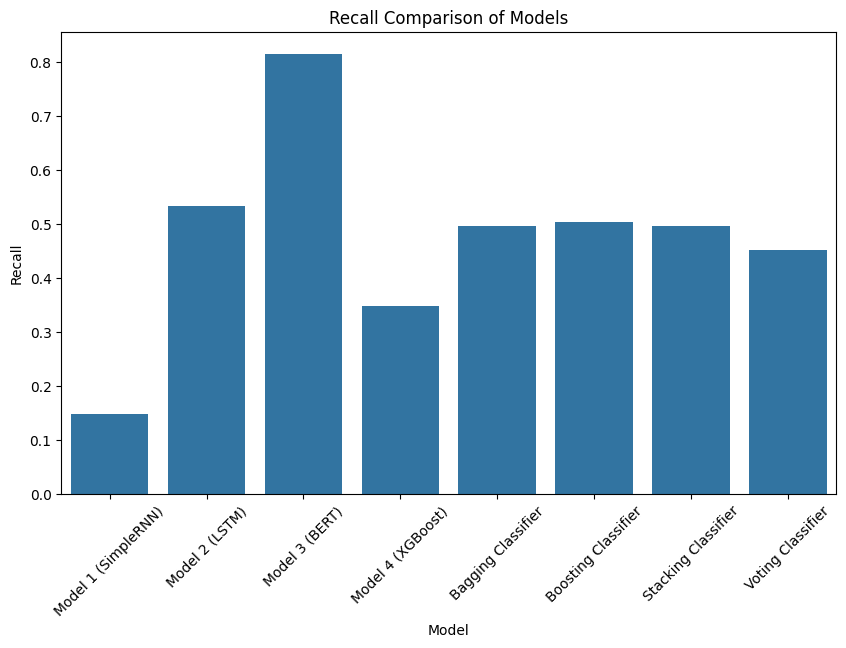

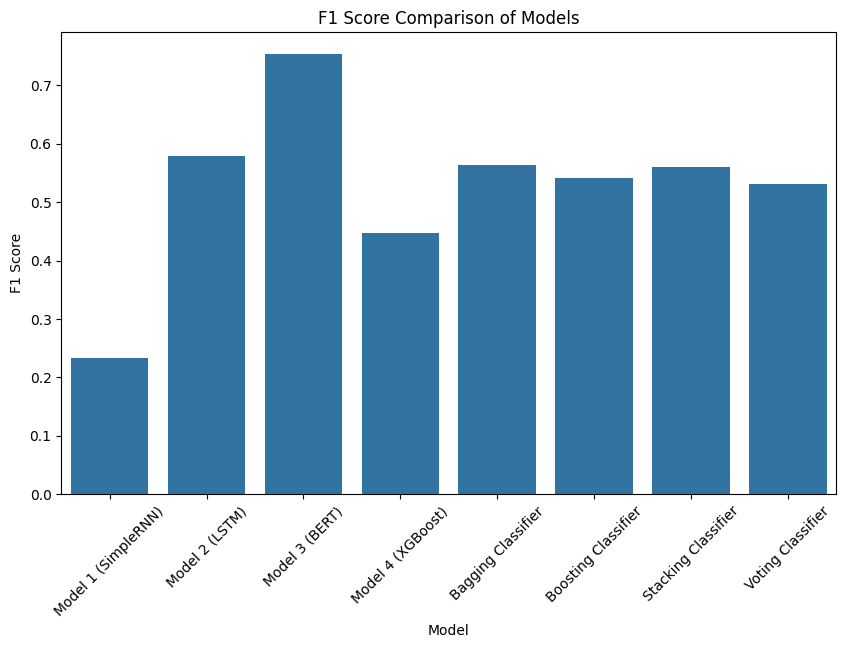

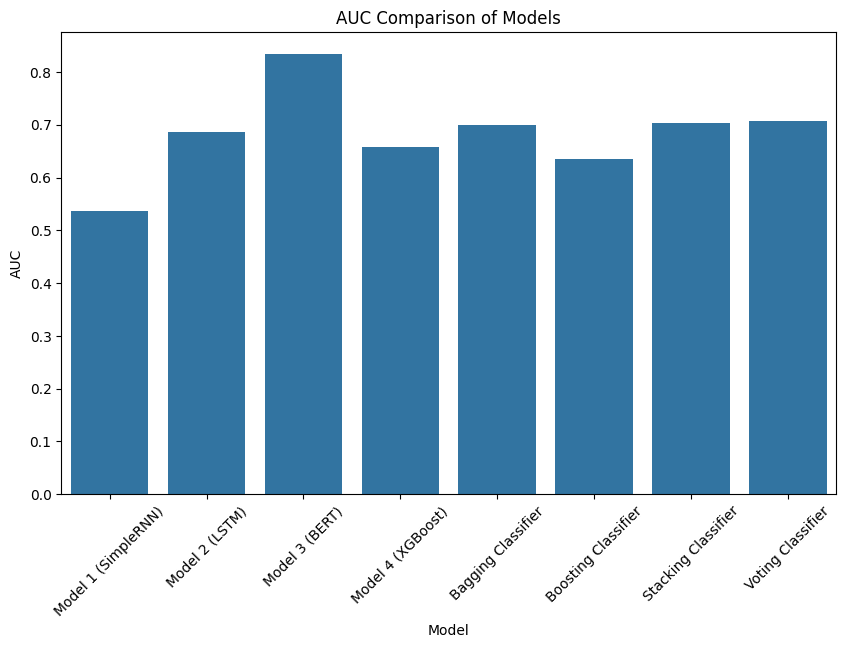

In [ ]:
# Compile results
results = [
    model1_results,
    model2_results,
    model3_results,
    model4_results,
    bagging_results,
    boosting_results,
    stacking_results,
    voting_results,
]

train_results = [
    model1_train_results,
    model2_train_results,
    model3_train_results,
    model4_train_results,
    bagging_train_results,
    boosting_train_results,
    stacking_train_results,
    voting_train_results,
]

train_results_df = pd.DataFrame(train_results)
train_results_df.set_index("Model", inplace=True)

results_df = pd.DataFrame(results)
results_df.set_index("Model", inplace=True)

print("\n\n===================== Training Data Evaluation Metrics =====================\n")
display(train_results_df)


# Display the results table
print("\n\n===================== Testing Data Evaluation Metrics =====================\n")
display(results_df)

# Plotting Accuracy Comparison
plt.figure(figsize=(10, 6))
sns.barplot(x=results_df.index, y='Accuracy', data=results_df.reset_index())
plt.title('Accuracy Comparison of Models')
plt.xticks(rotation=45)
plt.ylabel('Accuracy')
plt.show()

# Similarly, plot other metrics like Precision, Recall, F1 Score, and AUC
metrics = ['Precision', 'Recall', 'F1 Score', 'AUC']
for metric in metrics:
    plt.figure(figsize=(10, 6))
    sns.barplot(x=results_df.index, y=metric, data=results_df.reset_index())
    plt.title(f'{metric} Comparison of Models')
    plt.xticks(rotation=45)
    plt.ylabel(metric)
    plt.show()


## Interactive Prediction Widget

In [ ]:
import ipywidgets as widgets
from IPython.display import display

def predict_text(text):
    # Preprocess text as required by the model
    pred_prob = model3.predict([text])[0][0]
    pred_label = "Hate Speech" if pred_prob >= 0.5 else "No Hate Speech"
    print(f"Predicted Label: {pred_label}")
    print(f"Confidence: {pred_prob:.2f}")

text_widget = widgets.Textarea(
    value='Enter text here...',
    placeholder='Type something',
    description='Text:',
    disabled=False
)

output = widgets.Output()

def on_text_submit(change):
    with output:
        output.clear_output()
        predict_text(change['new'])

text_widget.observe(on_text_submit, names='value')

display(text_widget, output)

Textarea(value='Enter text here...', description='Text:', placeholder='Type something')

Output()